In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import math as mt
from datetime import date, datetime, timedelta
from IPython.display import clear_output
import scipy.stats as ss
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Get cwd as this changes depending on which laptop is being used.
# Could probably use a relative reference but this may restrict development.
# Import all required data from CSV files.

directory = os.getcwd()

growth_data_path = f"{directory}//growth_db.csv"
weather_data_path = f"{directory}//weather_db.csv"
zone_data_path = f"{directory}//zone_db.csv"
    
growth_data = pd.read_csv(growth_data_path)
weather_data = pd.read_csv(weather_data_path)
zone_data = pd.read_csv(zone_data_path)

In [3]:
# Ensure all data within a df is visible when printed.

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Variables used within script.

linearisation_power = 0.625 # This is used to transform mean_diameter so it has a linear relationship with solar/heat.
stripping_coef = 0.92 # This is to allow for a slight reduction in diameter once leeks are stripped at harvest.
min_grow_temp = 3 # The minimum temperature that leeks will grow at. Needed to calculate heat units.
max_grow_temp = 27 # The temperature at which maximum growth rate is achieved. Needed to calculate heat units.
season = datetime(2022, 1, 1) # Output data only required for fields with a planting date in this season.

In [5]:
# Feature creation, alteration and exploration for weather data.

weather_data['date'] = pd.to_datetime(weather_data['date'], format='%d/%m/%Y')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%H:%M:%S')
weather_data['day'] = weather_data.date.dt.day
weather_data['month'] = weather_data.date.dt.month
weather_data['day_month'] = weather_data['day'].astype(str) + " - " + weather_data['month'].astype(str) # This is used to calculate weather averages.

# Calculate heat_units using min and max temperature variables.

weather_data['heat_units'] = weather_data['avg_temp'] - min_grow_temp
weather_data['heat_units'] = np.where((weather_data['heat_units'] < 0), 0, weather_data['heat_units'])
weather_data['heat_units'] = np.where((weather_data['heat_units'] > max_grow_temp - min_grow_temp), 1, weather_data['heat_units']/24)

weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68656 entries, 0 to 68655
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             68656 non-null  datetime64[ns]
 1   time             68656 non-null  datetime64[ns]
 2   avg_temp         68656 non-null  float64       
 3   rh               68491 non-null  float64       
 4   rain             68655 non-null  float64       
 5   solar_radiation  68655 non-null  float64       
 6   wind_speed_gust  12246 non-null  float64       
 7   wind_speed_avg   68478 non-null  float64       
 8   soil_temp        12246 non-null  float64       
 9   bat_volt         66752 non-null  float64       
 10  leaf_wet         60962 non-null  float64       
 11  dew_point        60962 non-null  float64       
 12  day              68656 non-null  int64         
 13  month            68656 non-null  int64         
 14  day_month        68656 non-null  objec

In [6]:
# Investigate if any dates have something other than 24 datapoints as this must be an error.

weather_data.date.value_counts()[weather_data.date.value_counts()!=24]

2020-10-25    25
2021-02-25    25
2019-12-18    25
2021-10-31    25
2021-12-02    25
2021-12-01    25
2021-11-30    25
2020-06-06    25
2021-08-27    25
2022-01-12    23
2021-03-28    23
2021-08-26    23
2014-05-14    10
Name: date, dtype: int64

In [7]:
weather_data.head()

,date,time,avg_temp,rh,rain,solar_radiation,wind_speed_gust,wind_speed_avg,soil_temp,bat_volt,leaf_wet,dew_point,day,month,day_month,heat_units
0,2014-05-14,1900-01-01 14:00:00,15.8,55.9,0.0,457.0,NaN,2.7,NaN,6904.0,0.0,7.2,14,5,14 - 5,0.533333
1,2014-05-14,1900-01-01 15:00:00,17.0,51.2,0.0,1212.0,NaN,2.2,NaN,6952.0,0.0,7.0,14,5,14 - 5,0.583333
2,2014-05-14,1900-01-01 16:00:00,17.3,48.9,0.0,862.0,NaN,2.1,NaN,6922.0,0.0,6.6,14,5,14 - 5,0.595833
3,2014-05-14,1900-01-01 17:00:00,17.5,48.9,0.0,611.0,NaN,2.0,NaN,6904.0,0.0,6.7,14,5,14 - 5,0.604167
4,2014-05-14,1900-01-01 18:00:00,16.8,51.0,0.0,232.0,NaN,1.7,NaN,6894.0,0.0,6.7,14,5,14 - 5,0.575000


In [8]:
# Feature creation, alteration and exploration for growth data.

growth_data['sample_date'] = pd.to_datetime(growth_data['sample_date'], format='%d/%m/%Y')
growth_data['fieldzone'] = growth_data["field"] + " - " + growth_data["zone"].astype(str)
growth_data['stripped_diameter'] = growth_data['diameter'] * stripping_coef

growth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140585 entries, 0 to 140584
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sample_date        140585 non-null  datetime64[ns]
 1   field              140585 non-null  object        
 2   zone               140585 non-null  int64         
 3   diameter           140585 non-null  float64       
 4   fieldzone          140585 non-null  object        
 5   stripped_diameter  140585 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 6.4+ MB


In [9]:
growth_data.diameter.describe()

count    140585.000000
mean         19.868378
std           9.946228
min           1.000000
25%          12.000000
50%          19.000000
75%          27.000000
max          64.000000
Name: diameter, dtype: float64

In [10]:
growth_data.head()

,sample_date,field,zone,diameter,fieldzone,stripped_diameter
0,2019-07-17,Allans 18,1,4.0,Allans 18 - 1,3.68
1,2019-07-17,Allans 18,1,3.0,Allans 18 - 1,2.76
2,2019-07-17,Allans 18,1,5.0,Allans 18 - 1,4.60
3,2019-07-17,Allans 18,1,5.0,Allans 18 - 1,4.60
4,2019-07-17,Allans 18,1,3.0,Allans 18 - 1,2.76


In [11]:
# Feature creation, alteration and exploration for zone data.

zone_data['planting_date'] = pd.to_datetime(zone_data['planting_date'], format='%d/%m/%Y')
zone_data['harvest_date'] = pd.to_datetime(zone_data['harvest_date'], format='%d/%m/%Y')
zone_data['zone'] = zone_data['zone'].astype(int)
zone_data["fieldzone"] = zone_data["field"] + " - " + zone_data["zone"].astype(str)
zone_data["fieldvariety"] = zone_data["field"] + " - " + zone_data["variety"]

zone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   field           837 non-null    object        
 1   zone            837 non-null    int32         
 2   planting_date   837 non-null    datetime64[ns]
 3   variety         837 non-null    object        
 4   method          837 non-null    object        
 5   inputs          837 non-null    object        
 6   protection      837 non-null    object        
 7   planting_rate   837 non-null    int64         
 8   sand            837 non-null    int64         
 9   silt            837 non-null    int64         
 10  clay            837 non-null    int64         
 11  organic_matter  837 non-null    float64       
 12  harvest_date    837 non-null    datetime64[ns]
 13  fieldzone       837 non-null    object        
 14  fieldvariety    837 non-null    object        
dtypes: dat

In [12]:
zone_data.describe()

,zone,planting_rate,sand,silt,clay,organic_matter
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,3.166069,255444.008363,38.323775,42.560335,19.115890,26.772521
std,2.287870,79244.150568,22.367987,17.340255,9.730198,24.149179
min,1.000000,169677.000000,0.000000,6.000000,1.000000,1.000000
25%,1.000000,200000.000000,22.000000,32.000000,13.000000,3.000000
50%,3.000000,243870.000000,38.000000,42.000000,18.000000,19.900000
75%,4.000000,260538.000000,47.000000,55.000000,24.000000,40.000000
max,16.000000,538138.000000,90.000000,82.000000,49.000000,81.000000


In [13]:
zone_data.head()

,field,zone,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldzone,fieldvariety
0,Allans 07,1,2019-04-01,Krypton,Drilled,Conventional,Barley,249820,39,37,24,29.6,2019-12-15,Allans 07 - 1,Allans 07 - Krypton
1,Allans 07,2,2019-04-01,Krypton,Drilled,Conventional,Barley,249820,39,37,24,29.6,2019-12-15,Allans 07 - 2,Allans 07 - Krypton
2,Allans 07,3,2019-04-01,Longton,Drilled,Conventional,Barley,256524,39,37,24,29.6,2019-12-15,Allans 07 - 3,Allans 07 - Longton
3,Allans 07,4,2019-04-01,Longton,Drilled,Conventional,Barley,256524,39,37,24,29.6,2019-12-15,Allans 07 - 4,Allans 07 - Longton
4,Allans 07,5,2019-04-01,Batter,Drilled,Conventional,Barley,247048,39,37,24,29.6,2019-12-15,Allans 07 - 5,Allans 07 - Batter


In [14]:
# Start to build summary dataframe
# This dataframe will be aggregated to fit models. Need to aggregate explained later.

summary_data = growth_data.copy()

summary_data["zone"] = summary_data["zone"].astype(str)
summary_data["fieldzone"] = summary_data["field"] + " - " + summary_data["zone"]
summary_data['fieldzonedate'] = summary_data['fieldzone'] + " - " + summary_data['sample_date'].astype(str)

summary_data = summary_data.set_index('fieldzone')
summary_data = summary_data.join(zone_data.set_index('fieldzone'), rsuffix = '_join')

summary_data['fieldvarietydate'] = summary_data['fieldvariety'] + " - " + summary_data['sample_date'].astype(str)
summary_data['heat_units'] = 0
summary_data['solar_radiation'] = 0

summary_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140585 entries, Allans 06 - 1 to Wissey O (S) - 3
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sample_date        140585 non-null  datetime64[ns]
 1   field              140585 non-null  object        
 2   zone               140585 non-null  object        
 3   diameter           140585 non-null  float64       
 4   stripped_diameter  140585 non-null  float64       
 5   fieldzonedate      140585 non-null  object        
 6   field_join         140585 non-null  object        
 7   zone_join          140585 non-null  int32         
 8   planting_date      140585 non-null  datetime64[ns]
 9   variety            140585 non-null  object        
 10  method             140585 non-null  object        
 11  inputs             140585 non-null  object        
 12  protection         140585 non-null  object        
 13  planting_rate      140585 n

In [15]:
# Reset index and remove join columns from summary dataframe.

summary_data = summary_data.reset_index(inplace=False)
summary_data = summary_data.drop(columns=['field_join', 'zone_join'], inplace=False)
summary_data.head()

,fieldzone,sample_date,field,zone,diameter,stripped_diameter,fieldzonedate,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldvariety,fieldvarietydate,heat_units,solar_radiation
0,Allans 06 - 1,2021-07-29,Allans 06,1,13.0,11.96,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,2021-12-10,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
1,Allans 06 - 1,2021-07-29,Allans 06,1,14.0,12.88,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,2021-12-10,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
2,Allans 06 - 1,2021-07-29,Allans 06,1,8.0,7.36,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,2021-12-10,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
3,Allans 06 - 1,2021-07-29,Allans 06,1,10.0,9.20,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,2021-12-10,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
4,Allans 06 - 1,2021-07-29,Allans 06,1,7.0,6.44,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,2021-12-10,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0


In [16]:
# Skewness is how far the mode is to the right (positive) or left (negative) of the mean.
# Kurtosis is the length of the tails on the distribution. Normal distribution has kurtosis of 3.

def skewness(series):
    """Aggregate function to return skew of distribution"""
    return ss.skew(series, bias = False)

def kurt(series):
    """Aggregate function to return kurtosis of distribution"""
    return ss.kurtosis(series, bias = False)

In [17]:
# Aggregation of summary data to which can be used to fit models.
# Non aggregated data can also be used to fit models but it will be more difficult to create a predicted distribution...
# cont... due to not having a standard deviation variable which is generated during aggregation.

summary_data_avg = summary_data.copy()

summary_data_avg = summary_data_avg.groupby(['fieldzonedate']).agg({'stripped_diameter' : ['mean', 'std', 'count', skewness, kurt],
                                                                    'method' : ['first'],
                                                                    'inputs' : ['first'],
                                                                    'variety' : ['first'],
                                                                    'protection' : ['first'],
                                                                    'sand' : ['mean'],
                                                                    'silt' : ['mean'],
                                                                    'clay' : ['mean'],
                                                                    'organic_matter' : ['mean'],
                                                                    'planting_rate' : ['first'],
                                                                    'planting_date' : ['first'],
                                                                    'sample_date' : ['first'],
                                                                    'fieldzone' : ['first']}).reset_index()

summary_data_avg.columns = ['fieldzonedate',
                            'mean_diameter',
                            'std_dev_diameter',
                            'pp2m2',
                            'skewness',
                            'kurtosis',
                            'method',
                            'inputs',
                            'variety',
                            'protection',
                            'sand',
                            'silt',
                            'clay',
                            'organic_matter',
                            'planting_rate',
                            'planting_date',
                            'sample_date',
                            'fieldzone']

summary_data_avg['field'] = summary_data_avg['fieldzone'].str.split(' - ').str[0]
summary_data_avg['zone'] = summary_data_avg['fieldzone'].str.split(' - ').str[1]
summary_data_avg['d_lin'] = (summary_data_avg['mean_diameter'])**linearisation_power
summary_data_avg['s_lin'] = (summary_data_avg['std_dev_diameter'])**linearisation_power
summary_data_avg['heat_units'] = 0
summary_data_avg['solar_radiation'] = 0

summary_data_avg.tail()

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,protection,sand,silt,clay,organic_matter,planting_rate,planting_date,sample_date,fieldzone,field,zone,d_lin,s_lin,heat_units,solar_radiation
3596,Wissey O (S) - 1 - 2019-09-19,34.209474,5.277874,38,-0.366295,-0.436126,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,244843,2019-03-26,2019-09-19,Wissey O (S) - 1,Wissey O (S),1,9.095812,2.828374,0,0
3597,Wissey O (S) - 2 - 2019-07-30,18.447179,3.409484,39,0.261426,0.527252,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,244843,2019-03-26,2019-07-30,Wissey O (S) - 2,Wissey O (S),2,6.183099,2.152437,0,0
3598,Wissey O (S) - 2 - 2019-09-19,30.631818,4.797228,44,-0.065718,-0.292600,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,244843,2019-03-26,2019-09-19,Wissey O (S) - 2,Wissey O (S),2,8.489028,2.664520,0,0
3599,Wissey O (S) - 3 - 2019-07-30,20.079000,2.996661,40,0.333063,-0.493385,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,244843,2019-03-26,2019-07-30,Wissey O (S) - 3,Wissey O (S),3,6.519493,1.985631,0,0
3600,Wissey O (S) - 3 - 2019-09-19,29.920909,3.829350,44,-0.133634,-0.709054,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,244843,2019-03-26,2019-09-19,Wissey O (S) - 3,Wissey O (S),3,8.365352,2.314479,0,0


In [18]:
summary_data_avg[['method', 'inputs', 'variety', 'protection', 'fieldzone', 'field']].describe()

,method,inputs,variety,protection,fieldzone,field
count,3601,3601,3601,3601,3601,3601
unique,6,3,27,4,745,157
top,Drilled,Conventional,Krypton,Barley,Lords Ground 69/Tims - 1,Symmingtons HF1
freq,2202,3063,803,1730,8,92


In [19]:
summary_data_avg[['planting_date', 'sample_date']].describe(datetime_is_numeric=True)

,planting_date,sample_date
count,3601,3601
mean,2020-09-11 07:15:04.748680960,2021-02-02 15:38:32.357678336
min,2019-03-05 00:00:00,2019-07-17 00:00:00
25%,2020-04-13 00:00:00,2020-08-06 00:00:00
50%,2020-06-25 00:00:00,2021-03-02 00:00:00
75%,2021-04-23 00:00:00,2021-08-25 00:00:00
max,2021-08-01 00:00:00,2022-03-21 00:00:00


In [20]:
summary_data_avg[['mean_diameter', 'std_dev_diameter', 'pp2m2', 'skewness', 'kurtosis', 'sand', 'silt', 'clay', 'organic_matter', 'planting_rate']].describe()

,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,sand,silt,clay,organic_matter,planting_rate
count,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000
mean,18.534722,4.496539,39.040544,-0.285499,0.153487,37.557067,43.436823,19.006109,25.356623,247214.772563
std,7.855912,1.962594,9.497691,0.504365,1.028111,21.605905,17.658881,8.550112,23.848621,64101.931416
min,2.351111,0.580293,7.000000,-2.377850,-1.616494,0.000000,6.000000,1.000000,1.000000,169677.000000
25%,12.107200,2.994179,33.000000,-0.606754,-0.518920,22.000000,32.000000,13.000000,2.900000,200000.000000
50%,19.159000,4.390312,38.000000,-0.281775,-0.072394,38.000000,44.000000,18.000000,18.500000,248078.000000
75%,25.057895,5.840741,44.000000,0.039467,0.541729,45.000000,57.000000,24.000000,36.400000,260538.000000
max,40.725333,11.673648,86.000000,1.615237,8.091334,90.000000,82.000000,47.000000,78.700000,538138.000000


In [21]:
# Aggregation of weather data to create a more manageable dataframe as we only need day by day accuracy not hour by hour.

weather_data_avg = weather_data.copy()

weather_data_avg = weather_data_avg.groupby(['date']).agg({'rain' : ['sum'],
                                                       'heat_units' : ['sum'],
                                                       'solar_radiation' : ['sum'],
                                                       'wind_speed_avg' : ['mean'],
                                                       'rh' : ['mean'],
                                                       'avg_temp' : ['mean']}).reset_index()

weather_data_avg.columns = ['date',
                            'rain',
                            'heat_units',
                            'solar_radiation',
                            'wind_speed_avg',
                            'rh',
                            'avg_temp']

weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)

# Further aggregation of weather to get the average weather for a given day and a given month, regardless of the year.
# This average weather will be used to predict heat and solar that a plant will receive.
# Could possibly introduce some sort of short term weather forecast here???

weather_data_avg_group = weather_data_avg.copy()

weather_data_avg_group = weather_data_avg_group.groupby(['day_month']).agg({'rain' : ['mean'],
                                                                            'heat_units' : ['mean'],
                                                                            'solar_radiation' : ['mean'],
                                                                            'wind_speed_avg' : ['mean'],
                                                                            'rh' : ['mean'],
                                                                            'avg_temp' : ['mean']}).reset_index()

weather_data_avg_group.columns = ['day_month',
                                  'rain',
                                  'heat_units',
                                  'solar_radiation',
                                  'wind_speed_avg',
                                  'rh',
                                  'avg_temp']

# Extend aggregated weather data by adding 300 days of predicted weather.

max_date = max(weather_data_avg.date)

for i in range(1, 300):
    
    clear_output(wait=True)
    
    date = max_date + timedelta(days=i)
    weather_data_avg = weather_data_avg.append({'date': date,
                                                'rain': np.nan,
                                                'heat_units':np.nan,
                                                'solar_radiation':np.nan,
                                                'wind_speed_avg':np.nan,
                                                'rh':np.nan,
                                                'avg_temp':np.nan }, ignore_index=True)
    
    print("Current Progress:", np.round(i/300*100,0),"%")
    
weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)  

weather_data_avg.tail()

Current Progress: 100.0 %


,date,rain,heat_units,solar_radiation,wind_speed_avg,rh,avg_temp,day,month,day_month
3155,2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2 - 1
3156,2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3 - 1
3157,2023-01-04,NaN,NaN,NaN,NaN,NaN,NaN,4,1,4 - 1
3158,2023-01-05,NaN,NaN,NaN,NaN,NaN,NaN,5,1,5 - 1
3159,2023-01-06,NaN,NaN,NaN,NaN,NaN,NaN,6,1,6 - 1


In [22]:
weather_data_avg[weather_data_avg['solar_radiation']//1000000 != 0].head()

,date,rain,heat_units,solar_radiation,wind_speed_avg,rh,avg_temp,day,month,day_month
2861,2022-03-14,NaT,NaT,NaT,NaT,NaT,NaT,14,3,14 - 3
2862,2022-03-15,NaN,NaN,NaN,NaN,NaN,NaN,15,3,15 - 3
2863,2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,16,3,16 - 3
2864,2022-03-17,NaN,NaN,NaN,NaN,NaN,NaN,17,3,17 - 3
2865,2022-03-18,NaN,NaN,NaN,NaN,NaN,NaN,18,3,18 - 3


In [23]:
###THIS IS A VERY SLOW PROCESS (COULD PARALLEL PROCESSING BE INTRODUCED???)

def mean_weather(day_month, variable):
    """function that calculates the average value for a weather variable for a given day within a given month"""
    df = weather_data_avg_group[weather_data_avg_group['day_month']==day_month]
    weather_value = df[variable].sum()
    return weather_value

for variable in ['rain', 'heat_units', 'solar_radiation', 'wind_speed_avg', 'rh', 'avg_temp']:
    for i in weather_data_avg.index:
        
        clear_output(wait=True)
        
        # If statement so only future dates have weather predicted.
        # Tried == np.nan, but that didn't work so workaround implemented. Make sure no variable has a value larger than 'MEGA_NUM'.
        
        MEGA_NUM = 10000000
        
        if weather_data_avg[variable][i]//MEGA_NUM != 0:
            day_month = weather_data_avg['day_month'][i]
            weather_data_avg[variable][i] = mean_weather(day_month, variable)
            
        print(f"{variable} progress:", np.round(i/len(weather_data_avg)*100,0),"%")
    
weather_data_avg.tail()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
weather_data_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3160 entries, 0 to 3159
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3160 non-null   datetime64[ns]
 1   rain             3160 non-null   object        
 2   heat_units       3160 non-null   object        
 3   solar_radiation  3160 non-null   object        
 4   wind_speed_avg   3160 non-null   object        
 5   rh               3160 non-null   object        
 6   avg_temp         3160 non-null   object        
 7   day              3160 non-null   int64         
 8   month            3160 non-null   int64         
 9   day_month        3160 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 247.0+ KB


In [25]:
def cumulative_weather(start, finish, weather_variable, weather_data):
    """Function used to find the cumulative weather input between 2 given dates"""
    df = weather_data.loc[(weather_data['date'] > start) & (weather_data['date'] < finish), [weather_variable]]
    total_units = df[weather_variable].sum()
    return total_units

In [26]:
# Overwrite solar radiation with the cumulative total that has been received between planting and sampling.

for i in summary_data_avg.index:
    
    clear_output(wait=True)
    
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['solar_radiation'][i] = cumulative_weather(planting_date, sample_date, 'solar_radiation', weather_data_avg)
    
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


In [27]:
# Overwrite heat units with the cumulative total that has been received between planting and sampling.

for i in summary_data_avg.index:
    clear_output(wait=True)
    
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['heat_units'][i] = cumulative_weather(planting_date, sample_date, 'heat_units', weather_data_avg)
    
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


In [28]:
# Dummy code for protection column while retaining the original 'protection' series within the dataframe for visualisation purposes.
# This allows a larger amount of data to be used within Lin Reg model as df does not need to be filtered based on protection.

summary_data_avg['protection_2'] = summary_data_avg['protection'].copy()
summary_data_avg = pd.get_dummies(summary_data_avg, columns = ['protection'], drop_first = False)
summary_data_avg.rename(columns={'protection_2': 'protection'}, inplace=True)

In [29]:
summary_data_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fieldzonedate      3601 non-null   object        
 1   mean_diameter      3601 non-null   float64       
 2   std_dev_diameter   3601 non-null   float64       
 3   pp2m2              3601 non-null   int64         
 4   skewness           3601 non-null   float64       
 5   kurtosis           3601 non-null   float64       
 6   method             3601 non-null   object        
 7   inputs             3601 non-null   object        
 8   variety            3601 non-null   object        
 9   sand               3601 non-null   float64       
 10  silt               3601 non-null   float64       
 11  clay               3601 non-null   float64       
 12  organic_matter     3601 non-null   float64       
 13  planting_rate      3601 non-null   int64         
 14  planting

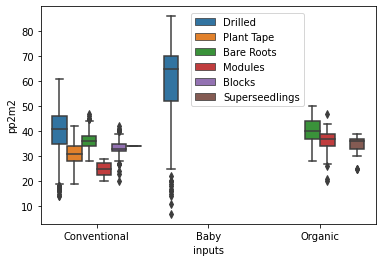

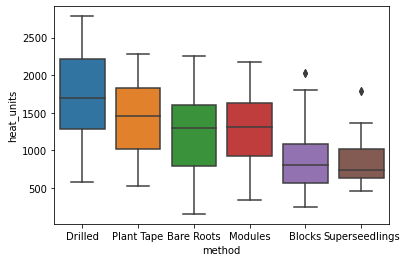

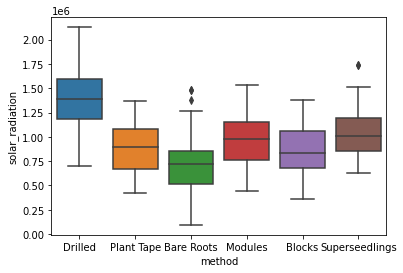

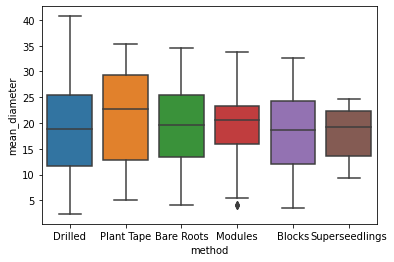

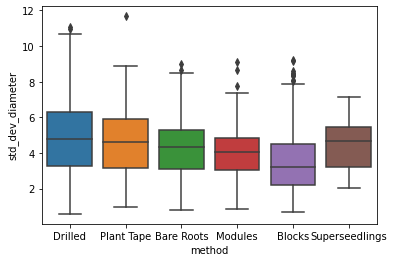

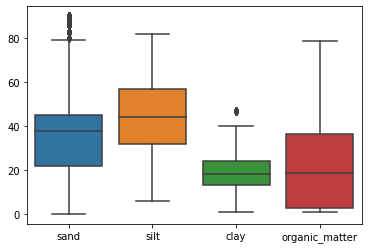

In [30]:
# Box plots to check for outliers in continuous variables of importance.

sns.boxplot(x = 'inputs', y = 'pp2m2', data = summary_data_avg, hue = 'method', orient = 'v')
plt.legend(bbox_to_anchor=(0.45, 0.97), loc='upper left', borderaxespad=0)
plt.show()

sns.boxplot(x = 'method', y = 'heat_units', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(x = 'method', y = 'solar_radiation', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(x = 'method', y = 'mean_diameter', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(x = 'method', y = 'std_dev_diameter', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(data = summary_data_avg[['sand', 'silt', 'clay', 'organic_matter']])
plt.show()

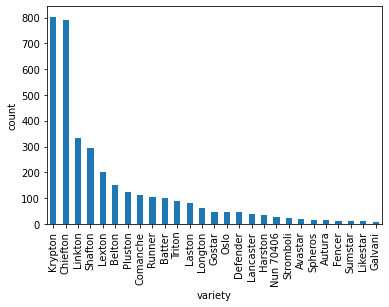

<Figure size 720x576 with 0 Axes>

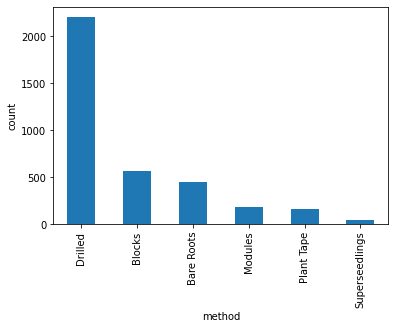

<Figure size 720x576 with 0 Axes>

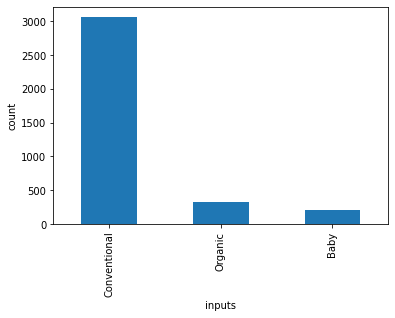

<Figure size 720x576 with 0 Axes>

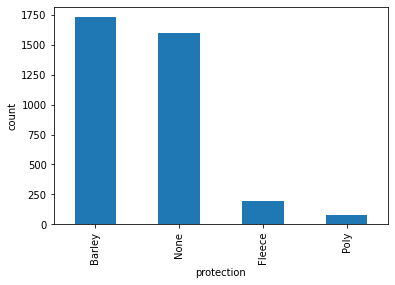

<Figure size 720x576 with 0 Axes>

In [31]:
# Value counts of categorical variables of importance.

summary_data_avg['variety'].value_counts().plot(kind = 'bar', xlabel = 'variety', ylabel = 'count')
plt.figure(figsize = (10, 8))
plt.show()

summary_data_avg['method'].value_counts().plot(kind = 'bar', xlabel = 'method', ylabel = 'count')
plt.figure(figsize = (10, 8))
plt.show()

summary_data_avg['inputs'].value_counts().plot(kind = 'bar', xlabel = 'inputs', ylabel = 'count')
plt.figure(figsize = (10, 8))
plt.show()

summary_data_avg['protection'].value_counts().plot(kind = 'bar', xlabel = 'protection', ylabel = 'count')
plt.figure(figsize = (10, 8))
plt.show()


In [32]:
# Check for any null values and if any are present, find out why.

summary_data_avg[summary_data_avg.isna().any(axis=1)]

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,sand,silt,clay,organic_matter,planting_rate,planting_date,sample_date,fieldzone,field,zone,d_lin,s_lin,heat_units,solar_radiation,protection,protection_Barley,protection_Fleece,protection_None,protection_Poly


In [33]:
#Remove any null values to prevent failure but if any are present, it's essential to find out why.

summary_data_avg = summary_data_avg.dropna()

In [34]:
def average_count(fieldzone, df_1 = summary_data_avg):
    """Function used to find the average plants per two meters squared from every sample from a given fieldzone over the entire season"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    average_count = df_1['pp2m2'].mean()
    
    if mt.isnan(average_count):
        average_count = 40
      
    return average_count

int(average_count('RH33 - 1')) == 36

False

In [35]:
def max_sample_date(fieldzone, df_1 = summary_data_avg, df_2 = zone_data):
    """Function used to find the most recent sample date for a given fieldzone"""
    
    df_1 = df_1[df_1['fieldzone'] == fieldzone]
    max_sample_date = max(df_1['sample_date'], default = 0)
    if max_sample_date == 0:
        df_2 = df_2[df_2['fieldzone'] == fieldzone]
        max_sample_date = df_2['planting_date'].max()
    
    return max_sample_date

max_sample_date('RH33 - 1')

Timestamp('2022-03-11 00:00:00')

In [36]:
def max_mean_diameter_lin(fieldzone, df_1 = summary_data_avg):
    """Function used to find the mean diameter of the sample at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_mean_diameter = df_1['mean_diameter'].max()
    max_mean_diameter_lin = max_mean_diameter ** linearisation_power
    
    if mt.isnan(max_mean_diameter_lin):
        max_mean_diameter_lin = 0
    
    return max_mean_diameter_lin

int(max_mean_diameter_lin('Allans 07 - 1')) == 9

True

In [37]:
def max_std_dev_diameter_lin(fieldzone, df_1 = summary_data_avg):
    """Function used to find the standard deviation of the sample at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_std_dev_diameter = df_1['std_dev_diameter'].max()
    max_std_dev_diameter_lin = max_std_dev_diameter ** linearisation_power
    
    if mt.isnan(max_std_dev_diameter_lin):
        max_std_dev_diameter_lin = 0
    
    return max_std_dev_diameter_lin

int(max_std_dev_diameter_lin('Allans 07 - 1')) == 4

True

In [38]:
def max_solar(fieldzone, df_1 = summary_data_avg):
    """Function used to find the solar radiation received at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_solar = df_1['solar_radiation'].max()
    
    if mt.isnan(max_solar):
        max_solar = 0
    
    return max_solar

max_solar('Allans 07 - 1') == 1600496

True

In [39]:
def max_heat(fieldzone, df_1 = summary_data_avg):
    """Function used to find the heat units received at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_heat = df_1['heat_units'].max()
    
    if mt.isnan(max_heat):
        max_heat = 0
    
    return max_heat

max_heat('Allans 07 - 1') == 2464

True

In [40]:
def filter_data(data, method, inputs, variety):
    """Function used to filter df so it only contains a single variety, input & method"""
    
    filtered = data[data['variety'].str.contains(variety)]
    filtered = filtered[filtered['inputs'].str.contains(inputs)]
    filtered = filtered[filtered['method'].str.contains(method)]
    
    return filtered

In [41]:
def predict_weather(start, finish, variable, df_1 = weather_data):
    """Function used to calculated a predicted weather variable for a given timeframe"""
    
    df_1 = df_1.loc[(df_1['date'] > start) & (df_1['date'] < finish), [variable]]
    predicted_weather= df_1[variable].sum()
    
    return predicted_weather

start = datetime(year=2021, month=6, day=2, hour=13, minute=14, second=31)
finish = datetime(year=2022, month=6, day=2, hour=13, minute=14, second=31)

predict_weather(start, finish, 'rain') == 434

False

In [42]:
# This df will be used for Linear Regression model and Visualisation. Prediction will be taken from the most recent (maximum) sample date...
# The 'max' variables just indicate the result of the most recent sample at that zone.

zone_data['mean_pp2m2'] = 0.0
zone_data['max_sample_date'] = 0
zone_data['max_mean_diameter_lin'] = 0.0
zone_data['max_std_dev_diameter_lin'] = 0.0
zone_data['max_heat'] = 0.0
zone_data['max_solar'] = 0.0
zone_data['remaining_heat'] = 0.0
zone_data['remaining_solar'] = 0.0
zone_data['rain_after_planting'] = 0

for i in zone_data.index:
    
    clear_output(wait=True)
    
    fieldzone = zone_data.loc[i, 'fieldzone']
    zone_data.loc[i, 'mean_pp2m2'] = average_count(fieldzone)
    zone_data.loc[i, 'max_sample_date'] = max_sample_date(fieldzone)
    zone_data.loc[i, 'max_mean_diameter_lin'] = max_mean_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_std_dev_diameter_lin'] = max_std_dev_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_heat'] = max_heat(fieldzone)
    zone_data.loc[i, 'max_solar'] = max_solar(fieldzone)
    start = zone_data.loc[i, 'max_sample_date']
    finish = zone_data.loc[i, 'harvest_date']
    rain_start = zone_data.loc[i, 'planting_date']
    rain_finish = rain_start + timedelta(days = 14)
    zone_data.loc[i, 'remaining_heat'] = cumulative_weather(start, finish, 'heat_units', weather_data_avg)
    zone_data.loc[i, 'remaining_solar'] = cumulative_weather(start, finish, 'solar_radiation', weather_data_avg)
    zone_data.loc[i, 'rain_after_planting'] = cumulative_weather(rain_start, rain_finish, 'rain', weather_data_avg)  
    
    print("Current Progress:", np.round(i/len(zone_data)*100,0),"%")
    
zone_data['establishment'] = (zone_data['mean_pp2m2']/2*10000)/zone_data['planting_rate']

Current Progress: 100.0 %


In [43]:
# These columns will be populated within the Lin Reg script.

zone_data['est_mean_diameter_gain'] = 0.0
zone_data['est_std_dev_diameter_gain'] = 0.0
zone_data['est_mean_diameter'] = 0.0
zone_data['est_std_dev_diameter'] = 0.0